## VAE

Import required packages

In [2]:
import torch
from torch import optim
from ResVAE import ResVariationalAutoEncoder  # Assuming you have a VAE model defined in 'model.py'
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from train import load_cw

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAT_PATH = '../data/preprocessed.mat'

cw = load_cw(MAT_PATH)
cw_tensor = torch.tensor(cw).to(DEVICE)
train_data = TensorDataset(cw_tensor)

Training

In [20]:
# Configuration
INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 50
Z_DIM = 20
H_LAYERS = [2,2,2]
LR_RATE = 1e-3
BATCH_SIZE = 1024

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
model = ResVariationalAutoEncoder(input_dim=INPUT_DIM, h_dim=H_DIM, h_layers=H_LAYERS, z_dim=Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE, weight_decay=1e-5, betas=(0.9, 0.999))


model.to(DEVICE)

loader_size = len(train_loader)
data_size = len(cw_tensor)
loss_list = np.zeros(loader_size)  # To store reconstruction diff losses
recon_loss_list = np.zeros(loader_size)  # To store reconstruction losses
kl_loss_list = np.zeros(loader_size)         # To store KL divergence losses


In [21]:
NUM_EPOCHS = 5000
KL_RATE = 0.02

model.train()
for epoch in range(NUM_EPOCHS):
    

    for i, [cw] in enumerate(train_loader):
        cw = cw.to(DEVICE, dtype=torch.float32).view(cw.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(cw)

        # Compute loss
        loss, recon_loss, kl_loss = model.loss(x_reconstructed, cw, mu, sigma, KL_RATE)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append losses to the lists
        loss_list[i] = loss.item()
        recon_loss_list[i] = recon_loss.item()
        kl_loss_list[i] = kl_loss.item()

    # Calculate and print average losses for this epoch
    # avg_loss = loss_list.sum() / data_size
    # avg_recon_loss = recon_loss_list.sum() / data_size
    # avg_kl_loss = kl_loss_list.sum() / data_size
    avg_loss = loss_list.mean()
    avg_recon_loss = recon_loss_list.mean()
    avg_kl_loss = kl_loss_list.mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{NUM_EPOCHS} | Loss: {avg_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}")
        
    if epoch % 100 == 0:
        torch.save(model, './VAE_theta+bias1.pth')


Epoch 0/5000 | Loss: 19.7047, Reconstruction: 19.7018, KL: 0.1448
Epoch 10/5000 | Loss: 15.1773, Reconstruction: 15.1708, KL: 0.3244
Epoch 20/5000 | Loss: 5.4611, Reconstruction: 5.4153, KL: 2.2899
Epoch 30/5000 | Loss: 0.9938, Reconstruction: 0.7494, KL: 12.2222
Epoch 40/5000 | Loss: 0.9331, Reconstruction: 0.7808, KL: 7.6147
Epoch 50/5000 | Loss: 0.8529, Reconstruction: 0.7811, KL: 3.5931
Epoch 60/5000 | Loss: 0.8208, Reconstruction: 0.7810, KL: 1.9901
Epoch 70/5000 | Loss: 0.8040, Reconstruction: 0.7807, KL: 1.1638
Epoch 80/5000 | Loss: 0.7930, Reconstruction: 0.7800, KL: 0.6523
Epoch 90/5000 | Loss: 0.7817, Reconstruction: 0.7754, KL: 0.3135
Epoch 100/5000 | Loss: 0.7646, Reconstruction: 0.7621, KL: 0.1240
Epoch 110/5000 | Loss: 0.7621, Reconstruction: 0.7608, KL: 0.0630
Epoch 120/5000 | Loss: 0.7530, Reconstruction: 0.7519, KL: 0.0569
Epoch 130/5000 | Loss: 0.7242, Reconstruction: 0.7208, KL: 0.1712
Epoch 140/5000 | Loss: 0.6046, Reconstruction: 0.5855, KL: 0.9542
Epoch 150/5000 |

Visualize Latent Variables

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def visualize_latent_distribution(model, data_loader, device='cpu', input_size=100):
    model.eval()  # Set the model to evaluation mode
    zs = []  # List to store the latent variables

    with torch.no_grad():  # No need to track gradients
        for [x] in data_loader:
            # Handle DataLoader returning either (data, target) or just data
            x = x.to(device, dtype=torch.float32)
            if x.dim() > 2:  # If your data is in a higher dimensional shape (e.g., images)
                x = x.view(x.size(0), -1)  # Flatten the image
            # Ensure the flattened size matches the model's expected input size
            assert x.shape[1] == input_size, f"Input shape must be [batch_size, {input_size}], but got: {x.shape}"
            mu, sigma = model.encode(x)
            epsilon = torch.randn_like(sigma)
            print(mu[0], sigma[0], epsilon[0])
            z = mu + sigma * epsilon  # Reparameterization trick
            zs.append(z.cpu().numpy())  # Move z to CPU and convert to numpy

    zs = np.concatenate(zs, axis=0)  # Combine all batch zs into a single array

    if zs.shape[1] == 2:  # Check if the latent space is 2D
        plt.scatter(zs[:, 0], zs[:, 1], alpha=0.5)
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('Latent Variable Distribution')
        plt.show()
    else:
        print("Latent space is not 2D. Consider using dimensionality reduction for visualization.")
        print(zs.shape[1])

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming 'train_data' is defined and is a PyTorch Dataset
# Make sure your DataLoader is correctly set up to load the dataset
data_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
visualize_latent_distribution(model, data_loader, device, input_size=100)


Generate Data

In [11]:
def generate(num_examples=1, mu_vals=None, sigma_vals=None, z_dim=Z_DIM, input_dim=INPUT_DIM, save_path='./output.mat'):
    if mu_vals is None:
        mu = torch.zeros(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        mu = torch.tensor(mu_vals).to(DEVICE, dtype=torch.float).view(1, z_dim)

    if sigma_vals is None:
        sigma = torch.ones(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE).view(1, z_dim)

    generated_data = []
    
    model.eval()
    with torch.no_grad():
        for _ in range(num_examples):
            out = model.generate(mu, sigma)
            generated_data.append(out)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0).cpu().detach().numpy()

    # Save the generated data as a .mat file
    scipy.io.savemat(save_path, {'generated_data': generated_data})
    return generated_data


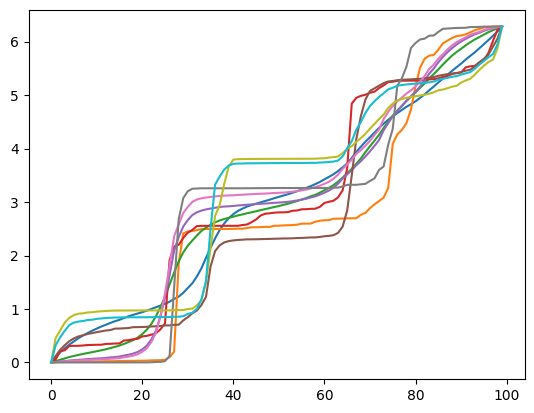

In [18]:
generated_data = generate(num_examples=10, save_path='./output_theta+bias1.mat')
# generated_data = cw.cpu().numpy()
angle = np.cumsum(generated_data, axis=1)
angle = (angle - angle[:, 0:1]) / (angle[:, -1] - angle[:, 0]).reshape(-1, 1) * 2 * np.pi
# angle[10]
for i in range(angle.shape[0]):
    plt.plot(angle[i])
# plt.plot(angle)